In [1]:
from accelerator import Lattice
from accelerator.elements import Dipole
from accelerator.elements import Drift
from accelerator.elements import QuadrupoleThin
from accelerator import Beam
from accelerator.utils import to_twiss, to_phase_coord
# from itertools import chain

import matplotlib.pyplot as plt

import numpy as np

# FODO cell

In [2]:
drift_l = 5  # m
focal_length = 10  # meters

FODO_cell = [QuadrupoleThin(focal_length), Drift(drift_l), QuadrupoleThin(-focal_length), Drift(drift_l)]
fodo = Lattice(FODO_cell)
fodo

Lattice([QuadrupoleThin(f=10, name='quadrupole_thin_0'), Drift(l=5, name='drift_0'), QuadrupoleThin(f=-10, name='quadrupole_thin_1'), Drift(l=5, name='drift_1')])

Oneturn transfer matrix

In [3]:
fodo.m_h

TransferMatrix([[ 0.25, 12.5 ,  0.  ],
                [-0.05,  1.5 ,  0.  ],
                [ 0.  ,  0.  ,  1.  ]])

twiss transfer matrix

In [4]:
fodo.m_h.twiss

TwissTransferMatrix([[ 6.2500e-02, -6.2500e+00,  1.5625e+02],
                     [ 1.2500e-02, -2.5000e-01, -1.8750e+01],
                     [ 2.5000e-03,  1.5000e-01,  2.2500e+00]])

Symplectic check.

$det(M_{one\_turn}) ==1$

In [5]:
np.linalg.det(fodo.m_h[:2, :2])

1.0

Stability check:

$|trace(M_{one turn})| < 2$

In [6]:
np.trace(fodo.m_h[:2, :2])

1.75

Periodic twiss solution:

In [7]:
twiss_sol = fodo.m_h.twiss_solution
twiss_sol

array([[25.81988897],
       [-1.29099445],
       [ 0.10327956]])

Let's check

In [8]:
np.allclose(twiss_sol, fodo.m_h.twiss @ twiss_sol)

True

### initial phase space shape

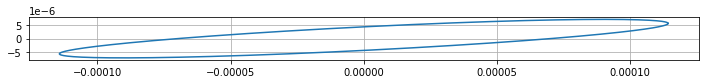

In [9]:
beam = Beam()
x, x_prime, dp = beam.ellipse(twiss_sol)
plt.figure(figsize=(12,12))
plt.plot(x, x_prime)
plt.gca().set_aspect('equal')
plt.grid()

# slicing an element

In [10]:
fodo.slice(Drift, 5)

Lattice([QuadrupoleThin(f=10, name='quadrupole_thin_0'), Drift(l=1.0, name='drift_0_slice_0'), Drift(l=1.0, name='drift_0_slice_1'), Drift(l=1.0, name='drift_0_slice_2'), Drift(l=1.0, name='drift_0_slice_3'), Drift(l=1.0, name='drift_0_slice_4'), QuadrupoleThin(f=-10, name='quadrupole_thin_1'), Drift(l=1.0, name='drift_1_slice_0'), Drift(l=1.0, name='drift_1_slice_1'), Drift(l=1.0, name='drift_1_slice_2'), Drift(l=1.0, name='drift_1_slice_3'), Drift(l=1.0, name='drift_1_slice_4')])

### twiss parameters along the FODO

In [11]:
beta, alpha, gamma, s = fodo.slice(Drift, 5).transport(twiss=twiss_sol)

We can check twiss periodicity

In [12]:
np.allclose(beta[0], beta[-1])

True

In [13]:
np.allclose(alpha[0], alpha[-1])

True

In [14]:
np.allclose(gamma[0], gamma[-1])

True

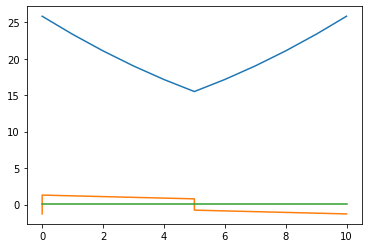

In [15]:
plt.plot(s, beta)
plt.plot(s, alpha)
plt.plot(s, gamma);

# transporting a particle

In [16]:
x, x_prime, dp, s = fodo.transport(phasespace=[1, 0, 0])  # phase space coords [x[m], x_prime[rad], dp/p]

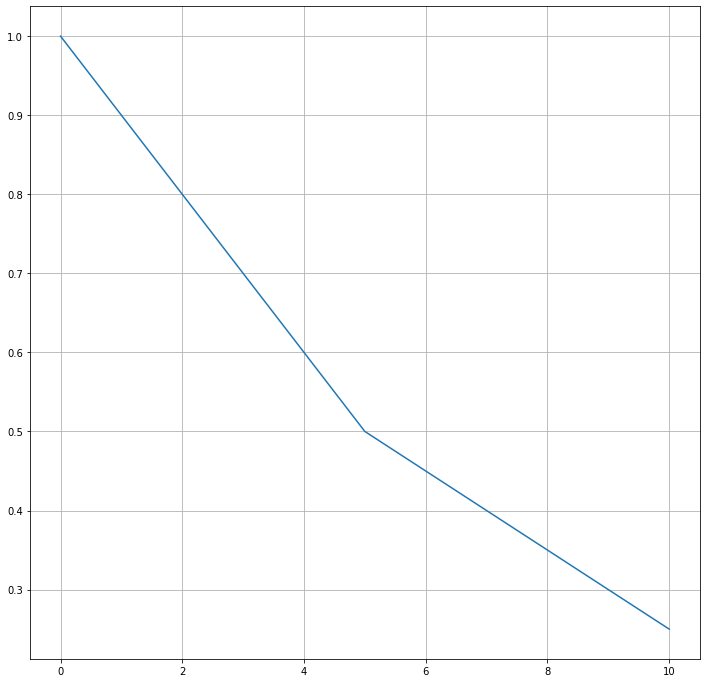

In [17]:
plt.figure(figsize=(12,12))
plt.plot(s, x)
# plt.gca().set_aspect('equal')
plt.grid()

# basic ring

In [18]:
n_fodo = 8
n_dipole = n_fodo # one dipole after each fodo
curve_perimeter = 120  # m
dip_theta = 2 * np.pi / n_dipole
dip_rho = curve_perimeter / (n_dipole * dip_theta)
drift_l = 10

In [19]:
dip = Dipole(dip_rho, dip_theta)

In [20]:
sequence = (FODO_cell + [dip, Drift(drift_l)]) * n_fodo
lattice = Lattice(sequence)

In [21]:
lattice.m_h

TransferMatrix([[-0.59487651, 35.05800156,  8.21587217],
                [-0.0445903 ,  0.94682959,  0.5863837 ],
                [ 0.        ,  0.        ,  1.        ]])

Stability condition:

In [22]:
np.trace(lattice.m_h[:2, :2])

0.3519530780440179

### Lattice layout

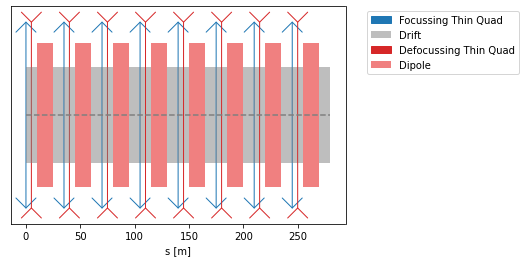

In [23]:
lattice.plot();

### Lattice overview

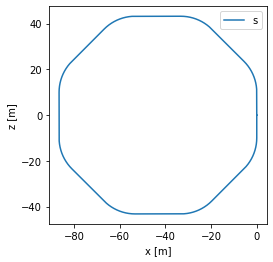

In [24]:
lattice.plot.top_down();

### Phasespace coords: tansporting a particle

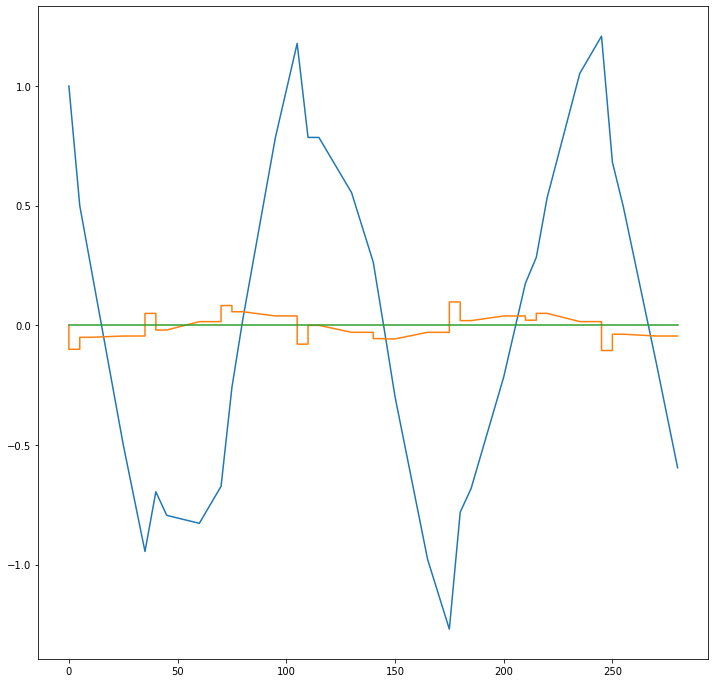

In [25]:
x, x_prime, dp, s = lattice.transport(phasespace=[1, 0, 0])
plt.figure(figsize=(12, 12))
plt.plot(s, x)
plt.plot(s, x_prime);
plt.plot(s, dp);

### Twiss parameters

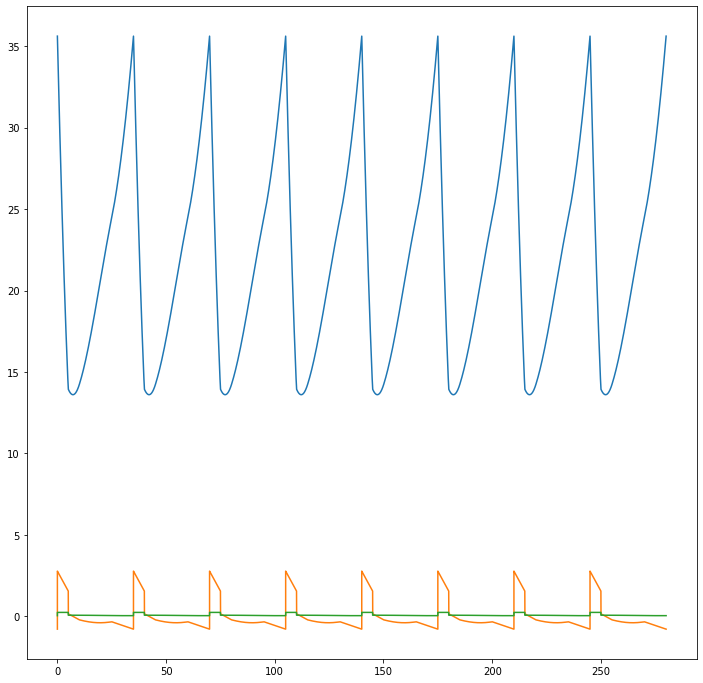

In [26]:
beta, alpha, gamma, s = lattice.slice(Dipole, 100).slice(Drift, 100).transport(twiss=lattice.m_h.twiss_solution)
plt.figure(figsize=(12,12))
plt.plot(s, beta)
plt.plot(s, alpha)
plt.plot(s, gamma)

### dispersion function

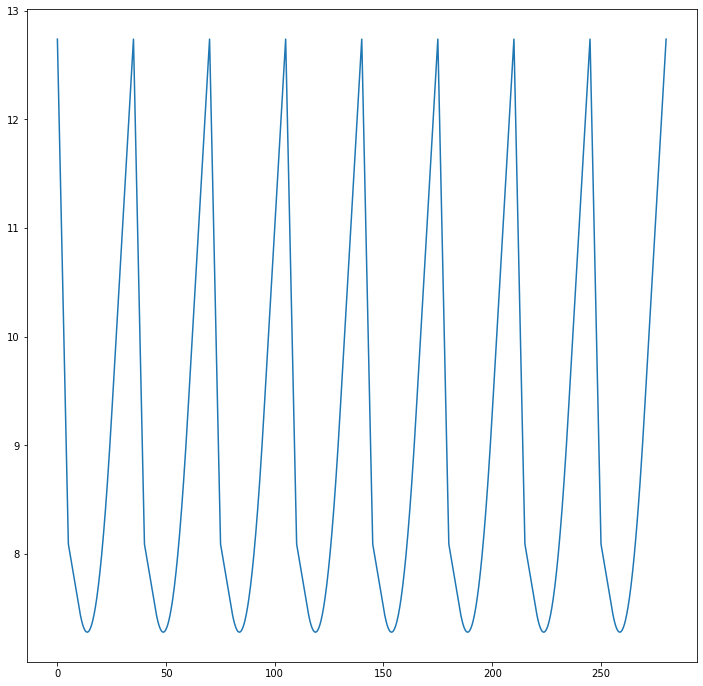

In [27]:
disp, disp_prime, dp, s = lattice.slice(Dipole, 100).slice(Drift, 100).transport(phasespace=lattice.m_h.dispersion_solution)
plt.figure(figsize=(12,12))
plt.plot(s, disp)

### Phasespace ellipses

In [28]:
x, x_prime, dp, s = lattice.transport(phasespace=Beam().ellipse(lattice.m_h.twiss_solution), plane='h')

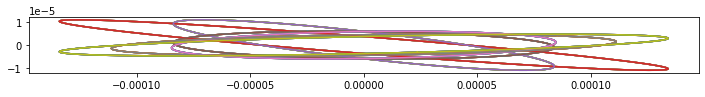

In [29]:
plt.figure(figsize=(12,12))
plt.plot(x, x_prime)
plt.gca().set_aspect('equal')

### particle trajectories

In [30]:
x, x_prime, dp, s = lattice.slice(Drift, 100)\
                       .slice(Dipole, 100)\
                       .transport(phasespace=Beam(n_particles=10).match(lattice.m_h.twiss_solution), plane='h')

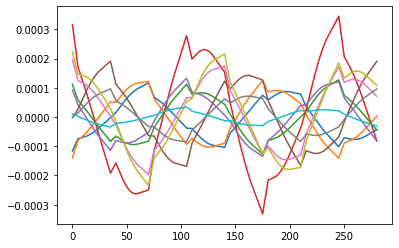

In [31]:
plt.plot(s, x.T);

# Now an unstable lattice

In [32]:
n_fodo = 8
n_dipole = n_fodo # one dipole after each fodo
curve_perimeter = 12  # m
dip_theta = 2 * np.pi / n_dipole
dip_rho = curve_perimeter / (n_dipole * dip_theta)
drift_l = 10

In [33]:
dip = Dipole(dip_rho, dip_theta)

In [34]:
sequence = (FODO_cell + [dip, Drift(drift_l)]) * n_fodo
lattice = Lattice(sequence)

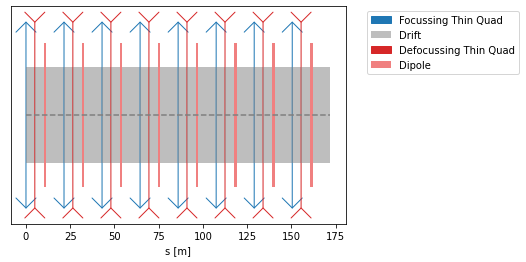

In [35]:
lattice.plot();

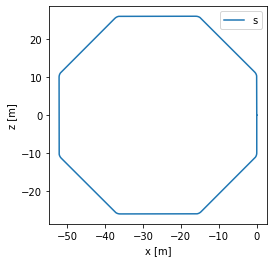

In [36]:
lattice.plot.top_down();

In [37]:
np.trace(lattice.m_h)

172933.63483852512

# tranporting a particle

In [38]:
x, x_prime, dp, s = lattice.transport(phasespace=[1, 0, 0], plane='h')

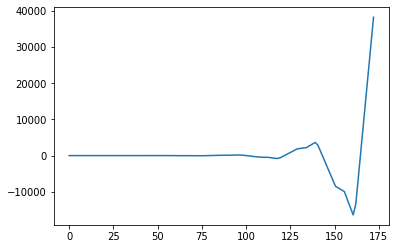

In [39]:
plt.plot(s, x);

# figure of 8 ring

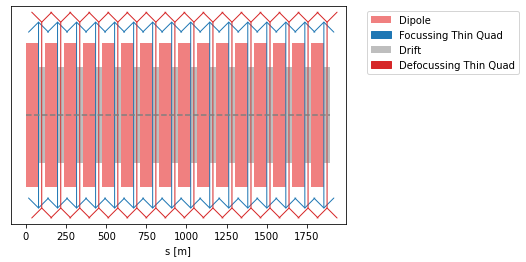

In [40]:
focal_length = 100
drift_l = 20
FODO_cell = [QuadrupoleThin(focal_length), Drift(drift_l), QuadrupoleThin(-focal_length), Drift(drift_l)]

wing_1 = ([Dipole(100, np.pi/4)] + FODO_cell) * 8
wing_2 = ([Dipole(-100, -np.pi/4)] + FODO_cell) * 8

lattice = Lattice(wing_1 + wing_2)
fig, ax = lattice.plot()
# leg = ax.legend()
# leg.get_label()

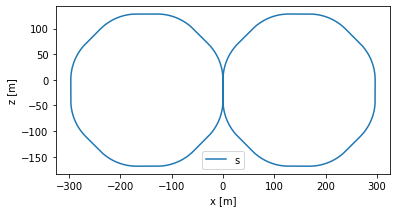

In [41]:
lattice.plot.top_down();

In [42]:
lattice.m_h.twiss_solution

array([[ 9.59416852e+01],
       [-2.71834775e-01],
       [ 1.11931966e-02]])

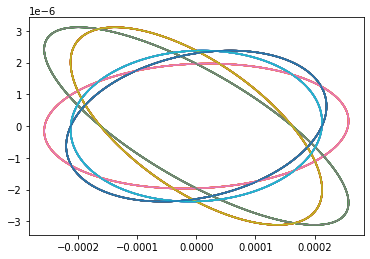

In [43]:
x, x_prime, dp, s = lattice.transport(phasespace=Beam().ellipse(lattice.m_h.twiss_solution))
plt.plot(x, x_prime);

In [44]:
beta, alpha, gamma, s = lattice.transport(twiss=lattice.m_h.twiss_solution)

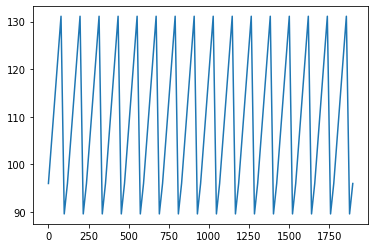

In [45]:
plt.plot(s, beta);